In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from datetime import date

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore
from pmdarima import auto_arima
import math
import pmdarima as pm
import tensorflow as tf
from unidecode import unidecode
from cmath import sqrt


import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
# Suppress warnings
warnings.filterwarnings("ignore")


## 1.1. Data collection

In [2]:
file_path = 'data/vietnam_macro_economic_by_month.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [3]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [4]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [5]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [6]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [7]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [8]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]
data = data.astype(float)

### 1.2.4. Detect outlier

In [9]:
model = IsolationForest(n_estimators=150, contamination=0.3)
model.fit(data)
y_anomaly = model.predict(data)
data[y_anomaly == -1] = np.median(data, axis=0)

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
data[data.columns] = scaled_data

### 1.2.5. Stationarity

#### Augmented Dickey-Fuller (ADF) test

Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).     
Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).   
Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).    
Indian Red: Evidence that the series is non-stationary. 

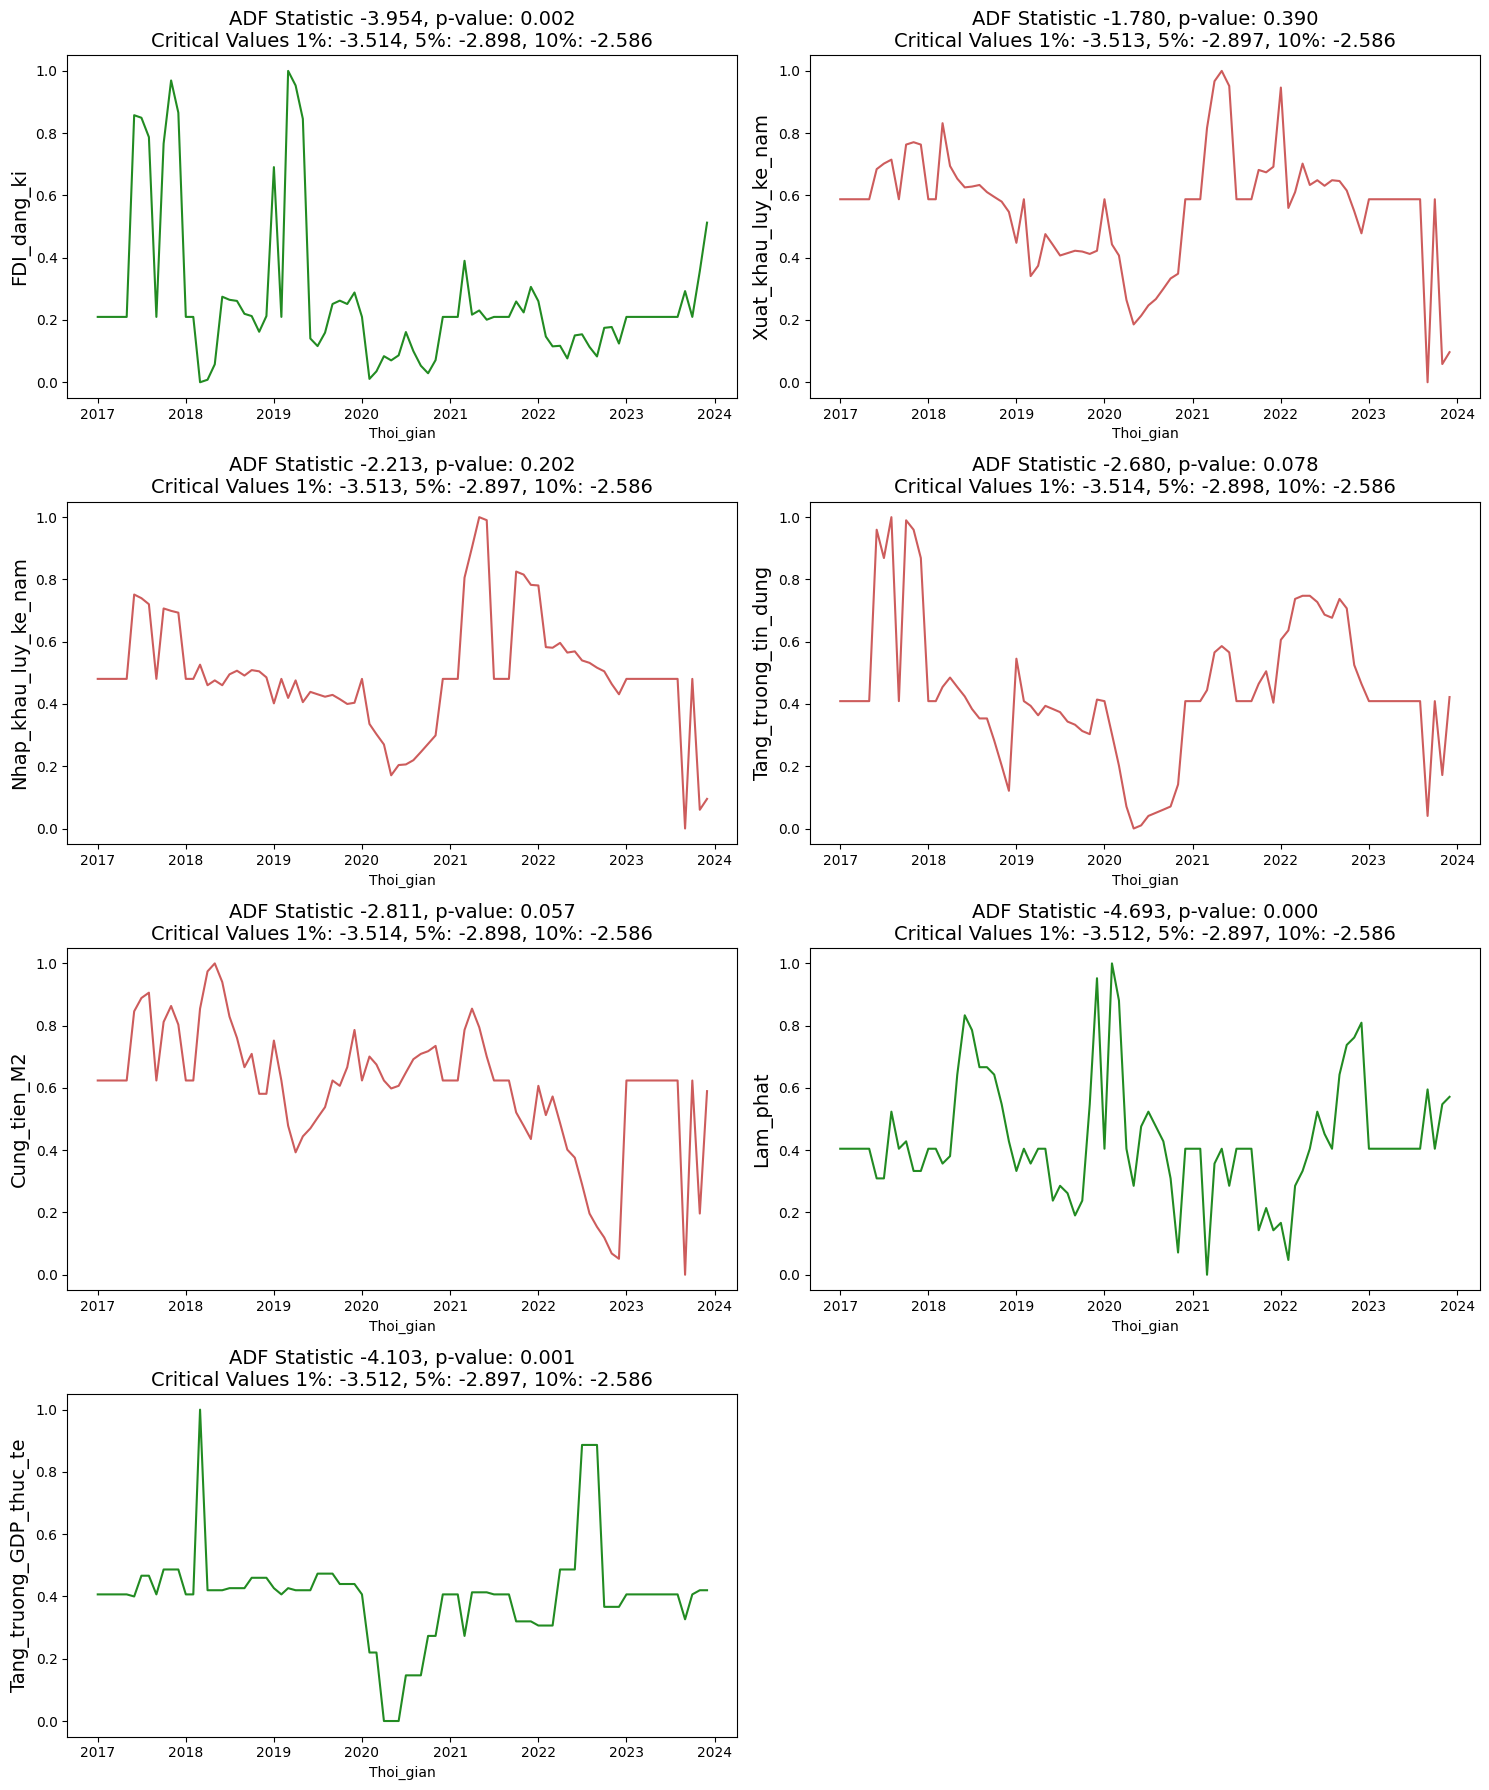

In [11]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng ngoài 2 feature là FDI_dang_ki, Lam_phat, Tang_truong_tin_dung và Tang_truong_GDP thực tế thì không có feature nào có tính dừng

### 1.4.2. Auto correlation

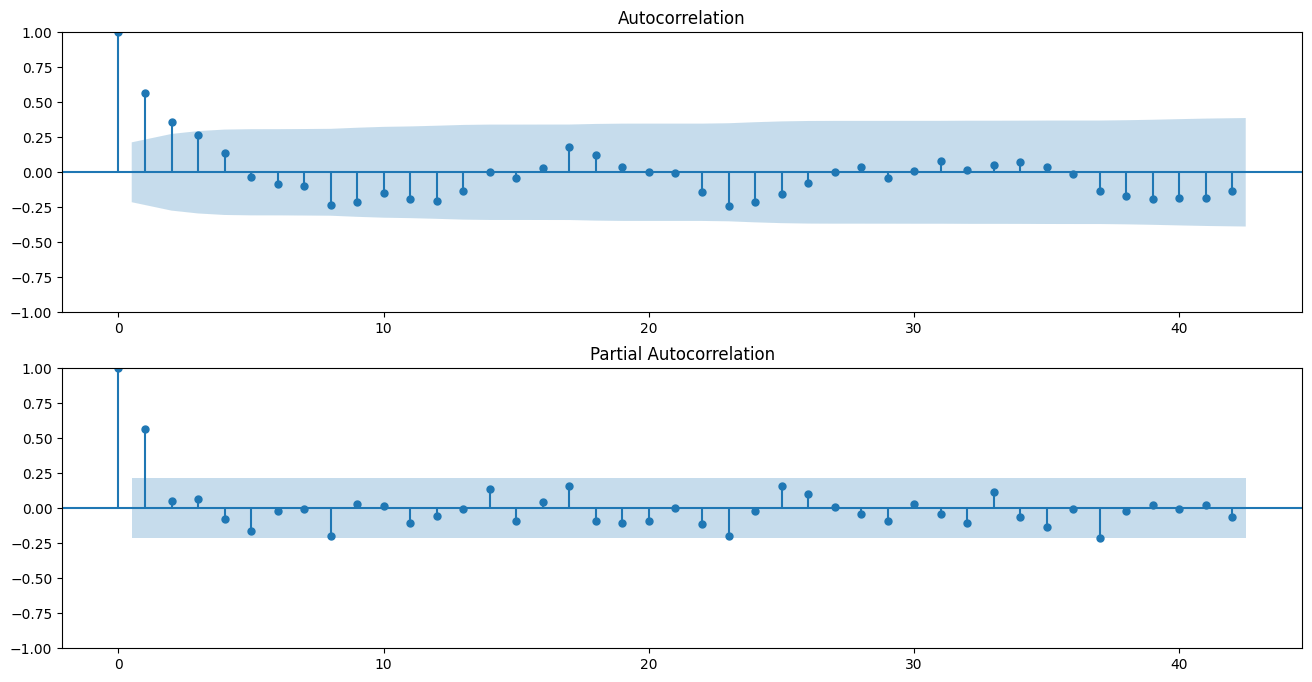

In [12]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Lam_phat,lags=42, ax=ax[0])
plot_pacf(data.Lam_phat,lags=42, ax=ax[1])
plt.show()

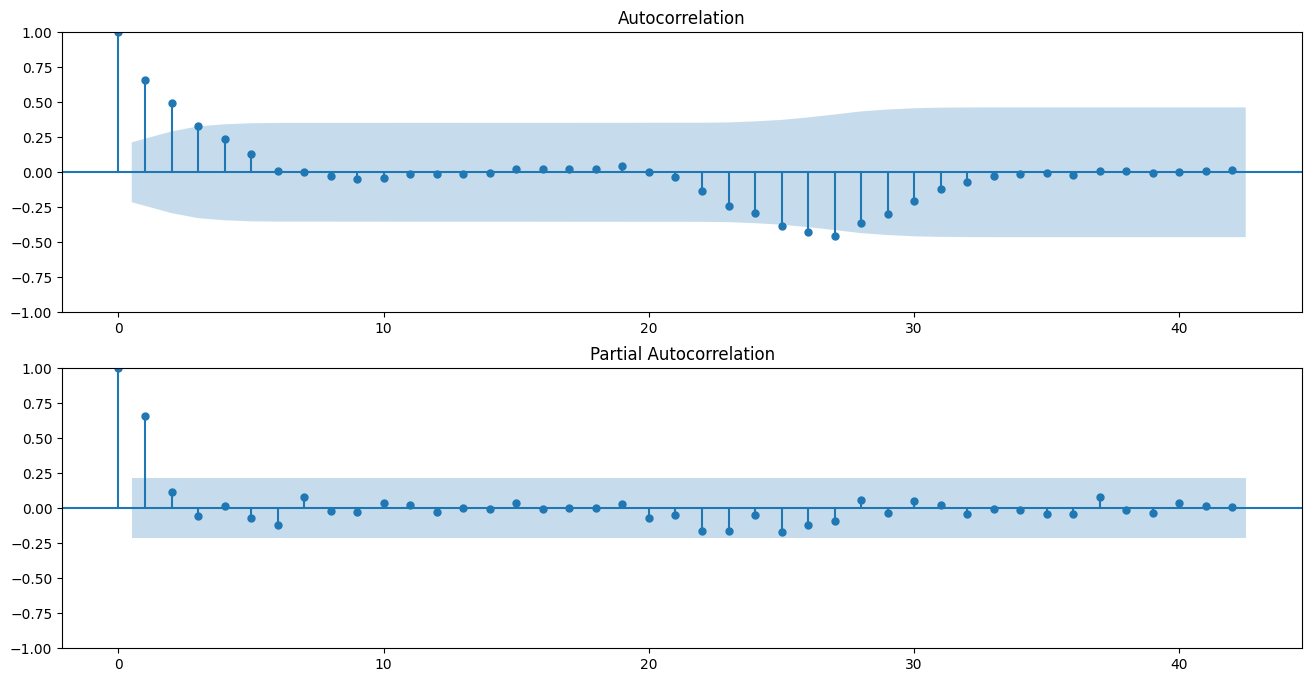

In [13]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

In [14]:
train_data = data['2017-01-01':'2021-05-01']
test_data = data['2021-06-01':'2023-12-01']
target_1 = 'Lam_phat'
y_train_1 = train_data[target_1]
y_test_1 = test_data[target_1]

target_2 = 'Tang_truong_GDP_thuc_te'
y_train_2 = train_data[target_2]
y_test_2 = test_data[target_2]

## 1.6. Model

In [15]:
model = ARIMA(y_train_1, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

forecast_1 = model_fit.forecast(steps=len(y_test_1)) 
forecast_1 = forecast_1.rename('Forecast_1')
mape_lamphat = np.mean(np.abs(forecast_1 - y_test_1)/np.abs(y_test_1))

                               SARIMAX Results                                
Dep. Variable:               Lam_phat   No. Observations:                   53
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  21.838
Date:                Thu, 23 May 2024   AIC                            -29.677
Time:                        18:32:05   BIC                            -15.885
Sample:                    01-01-2017   HQIC                           -24.373
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4362      0.073      5.960      0.000       0.293       0.580
ar.L1          0.1632      0.280      0.583      0.560      -0.386       0.712
ar.L2         -0.7143      0.273     -2.620      0.0

In [16]:
model = ARIMA(y_train_2, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

forecast_2 = model_fit.forecast(steps=len(y_test_2)) 
forecast_2 = forecast_2.rename('Forecast_2')
mape_gdp = np.mean(np.abs(forecast_2 - y_test_2)/np.abs(y_test_2))

                                  SARIMAX Results                                  
Dep. Variable:     Tang_truong_GDP_thuc_te   No. Observations:                   53
Model:                      ARIMA(3, 0, 2)   Log Likelihood                  41.113
Date:                     Thu, 23 May 2024   AIC                            -68.226
Time:                             18:32:05   BIC                            -54.434
Sample:                         01-01-2017   HQIC                           -62.922
                              - 05-01-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3826      0.083      4.590      0.000       0.219       0.546
ar.L1          1.5887      0.782      2.031      0.042       0.056       3.122
ar.L2       

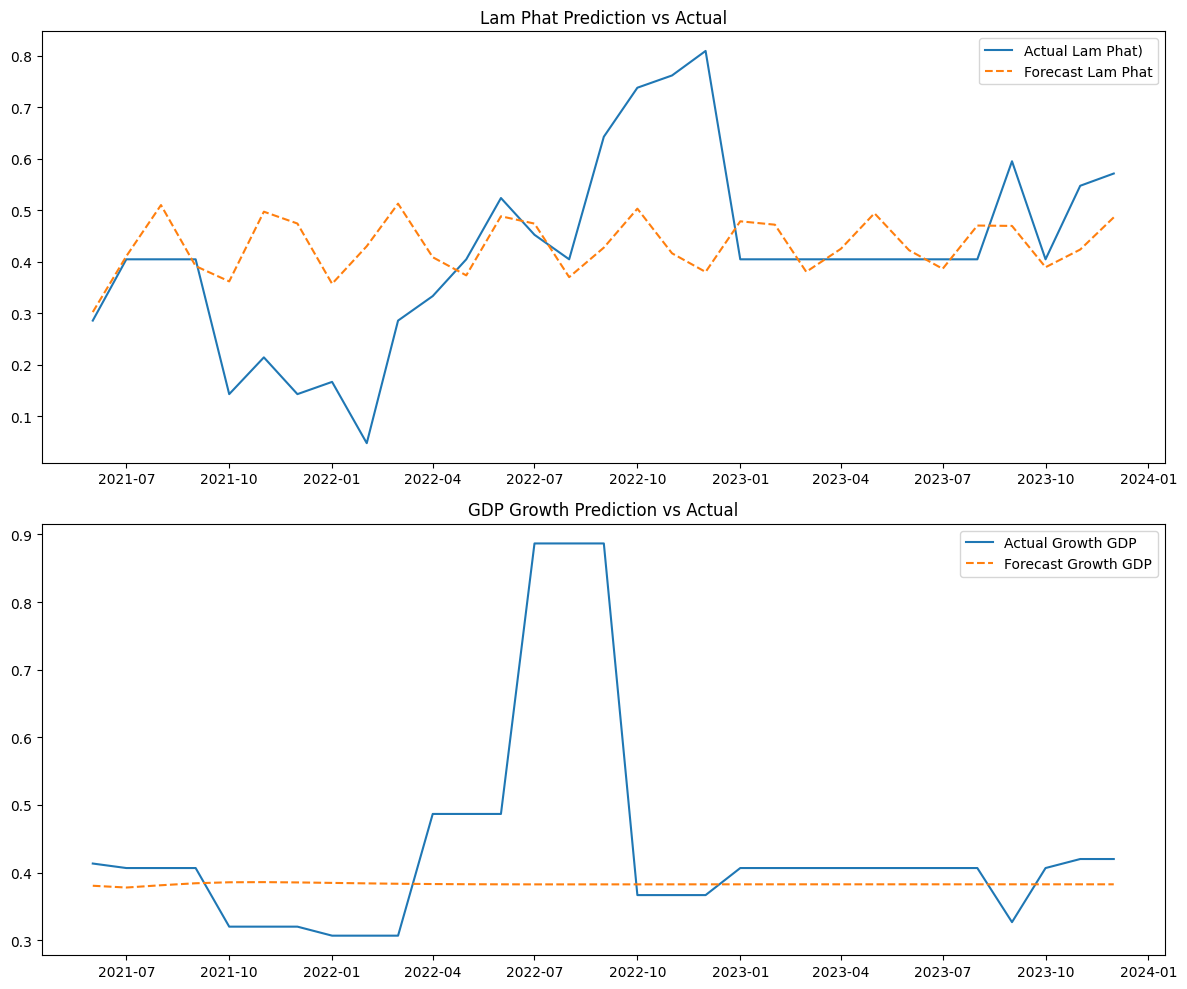

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(y_test_1, label=f'Actual Lam Phat)')
ax[0].plot(forecast_1, label='Forecast Lam Phat', linestyle='--')
ax[0].legend()
ax[0].set_title('Lam Phat Prediction vs Actual')

ax[1].plot(y_test_2, label=f'Actual Growth GDP')
ax[1].plot(forecast_2, label='Forecast Growth GDP', linestyle='--')
ax[1].legend()
ax[1].set_title('GDP Growth Prediction vs Actual')

plt.tight_layout()
plt.show()

### VARRNN

In [18]:
features = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
target = ['Tang_truong_tin_dung', 'Lam_phat', 'Tang_truong_GDP_thuc_te']


train_data = data['2017-01-01':'2021-05-01']
test_data = data['2021-06-01':'2023-12-01']

trainY = train_data[target]
trainX = train_data[features]

testY = test_data[target]
testX = test_data[features]

Tạo ra các đặc trưng trễ cho mỗi đặc trưng trong tập dữ liệu.   
Điều này có nghĩa là nó tạo ra các bản sao của các đặc trưng hiện có, nhưng dịch chuyển theo thời gian.     
Ví dụ, với p=4, nó tạo ra 4 bản sao của mỗi đặc trưng, mỗi bản sao được dịch chuyển 1, 2, 3 và 4 khoảng thời gian tương ứng.

In [19]:
p = 4

# Create lagged features
def create_lagged_features(data, features, p):
    lagged_data = pd.DataFrame(index=data.index)
    for feature in features:
        for lag in range(1, p + 1):
            lagged_data[f'{feature}_lag{lag}'] = data[feature].shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

In [20]:
trainX_lagged = create_lagged_features(trainX, features, p)
testX_lagged = create_lagged_features(testX, features, p)

# Update trainY and testY to match lagged features
trainY = trainY.loc[trainX_lagged.index]
testY = testY.loc[testX_lagged.index]

In [21]:
trainX_lagged.head()

,FDI_dang_ki_lag1,FDI_dang_ki_lag2,FDI_dang_ki_lag3,FDI_dang_ki_lag4,Xuat_khau_luy_ke_nam_lag1,Xuat_khau_luy_ke_nam_lag2,Xuat_khau_luy_ke_nam_lag3,Xuat_khau_luy_ke_nam_lag4,Nhap_khau_luy_ke_nam_lag1,Nhap_khau_luy_ke_nam_lag2,...,Cung_tien_M2_lag3,Cung_tien_M2_lag4,Lam_phat_lag1,Lam_phat_lag2,Lam_phat_lag3,Lam_phat_lag4,Tang_truong_GDP_thuc_te_lag1,Tang_truong_GDP_thuc_te_lag2,Tang_truong_GDP_thuc_te_lag3,Tang_truong_GDP_thuc_te_lag4
Thoi_gian,,,,,,,,,,,,,,,,,,,,,
2017-05-01,0.209910,0.209910,0.209910,0.20991,0.587786,0.587786,0.587786,0.587786,0.480583,0.480583,...,0.623932,0.623932,0.404762,0.404762,0.404762,0.404762,0.406667,0.406667,0.406667,0.406667
2017-06-01,0.209910,0.209910,0.209910,0.20991,0.587786,0.587786,0.587786,0.587786,0.480583,0.480583,...,0.623932,0.623932,0.404762,0.404762,0.404762,0.404762,0.406667,0.406667,0.406667,0.406667
2017-07-01,0.857658,0.209910,0.209910,0.20991,0.684478,0.587786,0.587786,0.587786,0.751456,0.480583,...,0.623932,0.623932,0.309524,0.404762,0.404762,0.404762,0.400000,0.406667,0.406667,0.406667
2017-08-01,0.849550,0.857658,0.209910,0.20991,0.702290,0.684478,0.587786,0.587786,0.739806,0.751456,...,0.623932,0.623932,0.309524,0.309524,0.404762,0.404762,0.466667,0.400000,0.406667,0.406667
2017-09-01,0.787387,0.849550,0.857658,0.20991,0.715013,0.702290,0.684478,0.587786,0.720388,0.739806,...,0.846154,0.623932,0.523810,0.309524,0.309524,0.404762,0.466667,0.466667,0.400000,0.406667


In [22]:
# Convert to numpy arrays for TensorFlow
trainX_lagged = trainX_lagged.to_numpy()
trainY = trainY.to_numpy()
testX_lagged = testX_lagged.to_numpy()
testY = testY.to_numpy()


In [23]:
trainX_lagged.shape[1]

28

In [24]:
# Define the number of output variables
num_outputs = len(target)
num_outputs

3

Xây dựng mô hình:

Mô hình bao gồm hai phần chính:     
ffnn_model: Một mạng neural đơn giản với một lớp Flatten để làm phẳng dữ liệu đầu vào và một lớp Dense với 64 neuron và hàm kích hoạt ReLU.         
var_model: Một lớp Dense khác để dự đoán các biến đầu ra (số lượng đầu ra được xác định bởi num_outputs).           
CustomModel: Một lớp tùy chỉnh được định nghĩa bằng cách kế thừa từ tf.keras.Model. Trong phương thức call, nó sử dụng ffnn_model để xử lý đầu vào và sau đó sử dụng var_model để tạo ra dự đoán.

In [25]:
# Build the model
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX_lagged.shape[1],)),  # Flatten the lagged input
    tf.keras.layers.Dense(64, activation='relu'),  # Example number of neurons
])

var_model = tf.keras.layers.Dense(num_outputs)

class CustomModel(tf.keras.Model):
    def __init__(self, ffnn_model, var_model):
        super(CustomModel, self).__init__()
        self.ffnn_model = ffnn_model
        self.var_model = var_model

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        var_output = self.var_model(ffnn_output)
        return var_output

In [26]:
custom_model = CustomModel(ffnn_model, var_model)
custom_model.compile(optimizer='adam', loss='mse')

In [27]:
custom_model.fit(trainX_lagged, trainY, verbose=1, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = custom_model.evaluate(testX_lagged, testY)
print(f'Test Loss: {loss}')

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.2302 - val_loss: 0.1083
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1665 - val_loss: 0.0758
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1173 - val_loss: 0.0531
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0804 - val_loss: 0.0387
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0617 - val_loss: 0.0313
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0501 - val_loss: 0.0286
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0493 - val_loss: 0.0282
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0496 - val_loss: 0.0289
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0514 - val_loss: 0.0297
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0512 - val_loss: 0.0297
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0500 - val_loss: 0.0286
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0481 - val_loss: 0.0271


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predictions on test data:
            Tang_truong_tin_dung  Lam_phat  Tang_truong_GDP_thuc_te
Thoi_gian                                                          
2021-10-01              0.329531  0.541286                 0.551662
2021-11-01              0.534490  0.407136                 0.461956
2021-12-01              0.473567  0.404761                 0.519422
2022-01-01              0.503817  0.392196                 0.560067
2022-02-01              0.455904  0.459189                 0.686643
2022-03-01              0.403771  0.370009                 0.588877
2022-04-01              0.423592  0.446656                 0.683562
2022-05-01              0.365202  0.500934                 0.590036
2022-06-01              0.387857  0.425625                 0.580710
2022-07-01              0.396250  0.488073                 0.637975
2022-08-01              0.311359  0.458884                 0.636217
2022-09-01              0.304216  0.395313         

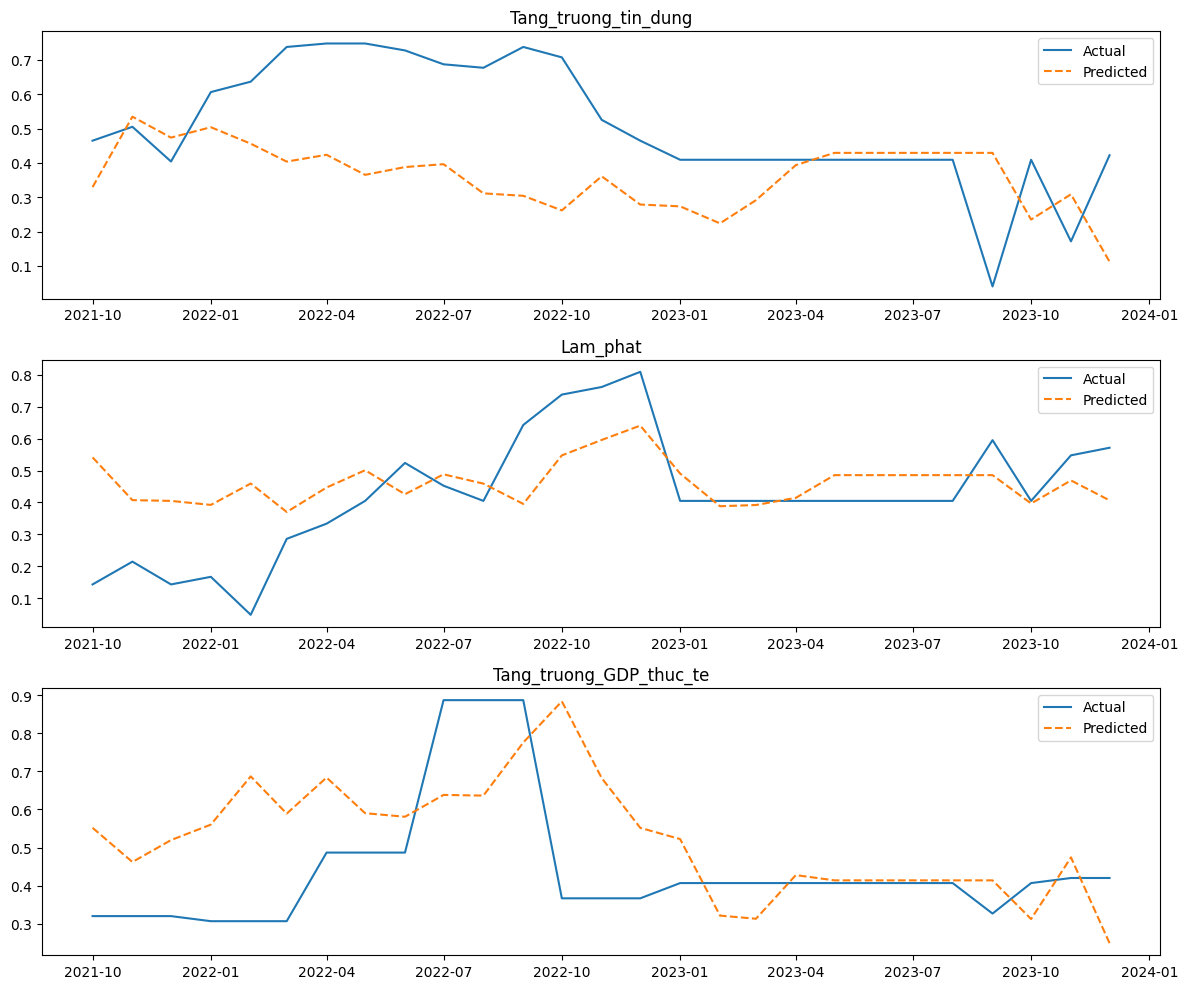

In [28]:
predictions = custom_model.predict(testX_lagged)
mse = mean_squared_error(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = sqrt(mean_squared_error(testY, predictions))

predictions_df = pd.DataFrame(predictions, index=test_data.index[p:], columns=target)

print("Predictions on test data:")
print(predictions_df)

plt.figure(figsize=(12, 10))
for i, col in enumerate(target):
    plt.subplot(len(target), 1, i+1)
    plt.plot(test_data.index[p:], testY[:, i], label='Actual')
    plt.plot(test_data.index[p:], predictions[:, i], label='Predicted', linestyle='--')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

In [29]:
mse

0.04212213877953597

In [30]:
rmse

(0.20523678710098725+0j)

In [31]:
mae

0.16221720405830178